In [1]:
import os
import mne
import numpy as np
from scipy import signal as sg
from matplotlib import pyplot as plt
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs
from mne_icalabel import label_components

c:\Users\Jeremi\anaconda3\envs\mne-label\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Utilities

In [2]:
class pan_tompkins_qrs():
    def bpf(self,x):
        
        y_filtered = None
        
        # x = np.squeeze(x)
        #Results will be delayed 16 Samples
        y = x.copy()

        #Low Pass Filter
        #y(n) = 2y(n-1) - y(n-2) + x(n) - 2x(n-6) + x(n-12)
        for n in range(len(x)):
            y[n] = x[n]

            if (n >= 1):
                y[n] += 2*y[n-1]
            if (n >= 2):
                y[n] -= y[n-2]
            if (n >= 6):
                y[n] -= 2*x[n-6]
            if (n >= 12):
                y[n] += x[n-12]
        
        y_filtered = y.copy()

        #High Pass Filter
        #y(n) = 32x(n-16) - y(n-1) - x(n) + x(n-32)
        for n in range(len(x)):
            y_filtered[n] = -1*y[n]

            if (n >= 1):
                y_filtered[n] -= y_filtered[n-1]
            if (n >= 16):
                y_filtered[n] += 32*y[n-16]
            if(n >= 32):
                y_filtered[n] += y[n-32]
        
        #Normalization
        max_val = max(max(y_filtered), -min(y_filtered))
        y_filtered = y_filtered/max_val

        return y_filtered
    
    def derivative(self,x,fs):
        
        #Results will be delayed for 2 samples
        y_derived = x.copy()
        
        #Derivative Filter
        #y(n) = [-x(n-2) - 2x(n-1) + 2x(n+1) + x(n+2)]/8
        for n in range(len(x)):
            y_derived[n] = 0

            if (n >= 1):
                y_derived[n] -= 2*x[n-1]
            if (n >= 2):
                y_derived[n] -= x[n-2]
            
            ###For this part [2x(n+1) + x(n+2)]###
            if (n >= 2 and n <= len(x)-2):
                y_derived[n] += 2*x[n+1]
            if (n >= 2 and n<= len(x)-3):
                y_derived[n] += x[n+2]
            ###For this part [2x(n+1) + x(n+2)]###

            ###In trasnfer function times 1/T, change to times fs###
            y_derived[n] = (y_derived[n]*fs)/8
            ###In trasnfer function times 1/T, change to times fs###
        
        return y_derived
    
    def squaring(self,x):
        
        y_squared = x.copy()

        for n in range(len(x)):
            y_squared[n] = x[n]**2

        return y_squared
    
    def moving_window_integration(self,x,fs):
        # Initialize result and window size for integration
        y = x.copy()
        win_size = round(0.150 * fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += x[j]/win_size
            y[j] = sum
        
        # Apply the moving window integration using the equation given
        for n in range(win_size,len(x)):  
            sum += x[n]/win_size
            sum -= x[n-win_size]/win_size
            y[n] = sum

        return y

    def solve(self,x,fs):

        # Convert the input signal into numpy array
        input_signal = x.copy()

        # Bandpass Filter
        global bpass
        bpass = self.bpf(input_signal)

        # Derivative Function
        global der
        der = self.derivative(bpass,fs)

        # Squaring Function
        global sqr
        sqr = self.squaring(der)

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr,fs)

        return mwin

class heart_rate():
    def __init__(self,x,fs):
        #Initialize Variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False
        self.m_win = mwin
        self.b_pass = bpass
        self.fs = fs
        # self.signal = np.squeeze(x)
        self.signal = x
        self.win_150ms = round(0.15*self.fs)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0

    def approx_peak(self):
        slopes = sg.fftconvolve(self.m_win, np.full((25,),1)/25, mode='same')

        # for i in range(round(0.5*self.fs) + 1,len(slopes)-1):
        for i in range(0,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] <slopes[i]):
                self.peaks.append(i)

    def adjust_rr_interval(self, ind):
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.fs  

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1
        
        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2
    
    def searchback(self, peak_val, RRn, sb_win):
        # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

            # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None
    
            # If the max peak value is found
            if (x_max is not None):   
                # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

                # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

                # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

                # Find the x location of the max peak value in the search window
                if (len(coord) > 0):
                    for pos in coord:
                        if (win_rr[pos] == max(win_rr[coord])):
                            r_max = pos
                            break
                else:
                    r_max = None

                # If the max peak value is found
                if (r_max is not None):
                # Update the thresholds corresponding to bandpass filter
                    if self.b_pass[r_max] > self.Threshold_F2:                                                        
                        self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                        self.Threshold_F2 = 0.5 * self.Threshold_F1      

                        # Append the probable R peak location                      
                        self.r_locs.append(r_max)

    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            if (ind > 0 and 0.20 < RRn < 0.36):
                # Find the slope of current and last waveform detected        
                curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
                last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
            
                # If current waveform slope is less than half of last waveform slope
                if (curr_slope < 0.5*last_slope):  
                    # T Wave is found and update noise threshold                      
                    self.T_wave = True                             
                    self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
            
        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))
        
        # Initialize a window to searchback
        win_200ms = round(0.2*self.fs)
    
    
    
        for r_val in self.r_locs:
            
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)
            
            # Find the x location of the max peak value
            if (len(coord) > 0):
                for pos in coord:               
                    if (self.signal[pos] == max(self.signal[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

            # Append the peak location
            if (x_max is not None):   
                self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''

        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
                x_coord = np.asarray(self.b_pass == max_val).nonzero()
                self.probable_peaks.append(x_coord[0][0])
                
            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits
                self.adjust_rr_interval(ind)
                
                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.fs))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
                # Adjust threholds
                self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return np.unique(self.result)
        
    
    

# Load Data

In [3]:
directory_path = "D:/EEG RESEARCH DATA"
os.chdir(directory_path)

####### List of Path ######
path = ['20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001.vhdr',
        '20240129_B71_mat5mins/20240129_B71_mat5mins_0001.vhdr',
        '20240418_B98_mat2mins/20240418_B98_jikken_0004.vhdr',
        '20240418_B98_mat5mins/20240418_B98_jikken_0003.vhdr',
        '20240418_B98_stroop2mins/20240418_B98_jikken_0002.vhdr',
        '20240418_B98_stroop5mins/20240418_B98_jikken_0001.vhdr',
        '20240725_X00_mat2mins/20240725_X00_jikken_0004.vhdr',
        '20240725_X00_mat5mins/20240725_X00_jikken_0003.vhdr',
        '20240725_X00_stroop2mins/20240725_X00_jikken_0002.vhdr',
        '20240725_X00_stroop5mins/20240725_X00_jikken_0001.vhdr']
####### List of Path ######

In [4]:
files = {number: path[number] for number in range(len(path))}

print(files)
file_number = int(input("Choose File: "))

{0: '20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001.vhdr', 1: '20240129_B71_mat5mins/20240129_B71_mat5mins_0001.vhdr', 2: '20240418_B98_mat2mins/20240418_B98_jikken_0004.vhdr', 3: '20240418_B98_mat5mins/20240418_B98_jikken_0003.vhdr', 4: '20240418_B98_stroop2mins/20240418_B98_jikken_0002.vhdr', 5: '20240418_B98_stroop5mins/20240418_B98_jikken_0001.vhdr', 6: '20240725_X00_mat2mins/20240725_X00_jikken_0004.vhdr', 7: '20240725_X00_mat5mins/20240725_X00_jikken_0003.vhdr', 8: '20240725_X00_stroop2mins/20240725_X00_jikken_0002.vhdr', 9: '20240725_X00_stroop5mins/20240725_X00_jikken_0001.vhdr'}


In [5]:
raw = mne.io.read_raw_brainvision(path[file_number], preload = True)

# Reconstruct the original events from our Raw object
events, event_ids = mne.events_from_annotations(raw)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_channel_types({'ECG':'ecg'})
raw.set_channel_types({'vEOG':'eog'})
raw.set_channel_types({'hEOG':'eog'})

raw.set_montage(montage)


Extracting parameters from 20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001.vhdr...
Setting channel info structure...
Reading 0 ... 958599  =      0.000 ...   958.599 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


<RawBrainVision | 20231019_B68_stroop5mins_0001.eeg, 67 x 958600 (958.6 s), ~490.1 MB, data loaded>

In [6]:
fs = 1000
tmin = events[3,0]/fs #Experiment Begin 
tmax = events[-1,0]/fs #Task Begin

if path[file_number] == "20231019_B68_stroop5mins/20231019_B68_stroop5mins_0001.vhdr":
    tmin = events[9,0]/fs
if path[file_number] == '20240725_X00_mat5mins/20240725_X00_jikken_0003.vhdr':
    tmax = events[-2,0]/fs
if path[file_number] == '20240725_X00_stroop5mins/20240725_X00_jikken_0001.vhdr':
    tmax = events[-2,0]/fs
if path[file_number] == '20240418_B98_stroop5mins/20240418_B98_jikken_0001.vhdr':
    tmax = tmin + 900

In [7]:
raw_temp = raw.copy().crop(tmin = tmin, tmax = tmax).apply_function(lambda x: -x, picks='ECG') #make a copy

In [8]:
def set_reference(raw = raw, car=False):
    dummy = raw.copy()
    if car == True:
        dummy.set_eeg_reference(ref_channels='average')
        data = dummy.copy().crop(tmin = tmin, tmax = tmax).apply_function(lambda x: -x, picks='ECG') #make a copy
        print("Return CAR Data")
    elif car == False:
        data = raw.copy().crop(tmin = tmin, tmax = tmax).apply_function(lambda x: -x, picks='ECG') #make a copy
        print("Return Non-CAR Data")
    return(data)

In [9]:
raw_non_car = set_reference(raw, car = False)
raw_car = set_reference(raw, car = True)

Return Non-CAR Data
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Return CAR Data


# ICA

In [10]:
def ica_raw(raw):
    filt_raw = raw.load_data().copy().filter(l_freq=1.0, h_freq=100)

    ica = ICA(n_components=15, max_iter="auto",method='infomax', fit_params=dict(extended=True), random_state = 95)
    ica.fit(filt_raw)
    ica

    ########## Labeling IC Components ##########
    ic_labels = label_components(filt_raw, ica, method="iclabel")
    print(ic_labels["labels"])

    labels = ic_labels["labels"]

    exclude_idx = [
        idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
    ]
    print(f"Excluding these ICA components: {exclude_idx}")
        
    ica.exclude = exclude_idx
    dummy = filt_raw.copy()
    ica.apply(dummy)

    return(dummy)

In [12]:
ica_non_car = ica_raw(raw_non_car)
ica_car = ica_raw(raw_car)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 116.5s.


C:\Users\Jeremi\AppData\Local\Temp\ipykernel_10012\2870148227.py:9: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(filt_raw, ica, method="iclabel")


['eye blink', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'other', 'muscle artifact', 'muscle artifact']
Excluding these ICA components: [0, 3, 8, 9, 10, 11, 13, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
    Projecting back using 64 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 118.4s.
['eye blink', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'other', 'muscle artifact', 'muscle artifact', 'other', 'other', 'muscle artifact', 'muscle artifact']
Excluding these ICA components: [0, 1, 7, 9, 10, 13, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 7 ICA components
    Projecting back using 64 PCA components


# Get R Peak Events

In [13]:
def extract_ecg_event():
    raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = tmin, tmax = tmax) #make a copy

    mne_ecg,_ = raw_ecg[:]
    mne_ecg = np.squeeze(-mne_ecg)

    b, a = sg.butter(2, [0.5, 150], 'bandpass', output= 'ba', fs=fs)
    mne_ecg = sg.filtfilt(b,a,mne_ecg)

    QRS_detector = pan_tompkins_qrs()
    output = QRS_detector.solve(mne_ecg, fs)

    # Find the R peak locations
    hr = heart_rate(mne_ecg,fs)
    result = hr.find_r_peaks()
    result = np.array(result)

    # Clip the x locations less than 0 (Learning Phase)
    result = result[result > 0]

    r_peak_onset = []
    for i in range(len(result)):
        ons_idx = int(fs*tmin)+result[i]
        r_peak_onset.append(ons_idx)

    pan_tompkins_events = np.zeros((len(r_peak_onset), 3), dtype=int)

    pan_tompkins_events[:, 0] = r_peak_onset
    pan_tompkins_events[:, 1] = 0 
    pan_tompkins_events[:, 2] = 7

    return(pan_tompkins_events)


In [14]:
pan_tompkins_events = extract_ecg_event()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


# Epoch Extract

In [15]:
epoch_tmin = -0.2
epoch_tmax = 0.6
baseline = (None,0)

In [16]:
car_filt_raw = ica_car.load_data().copy().filter(l_freq=1.0, h_freq=40, picks = ['eeg'])

car_epoch = mne.Epochs(car_filt_raw,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
car_evoked = car_epoch.average()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


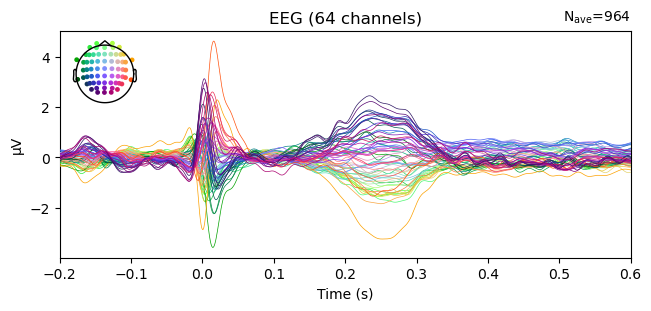

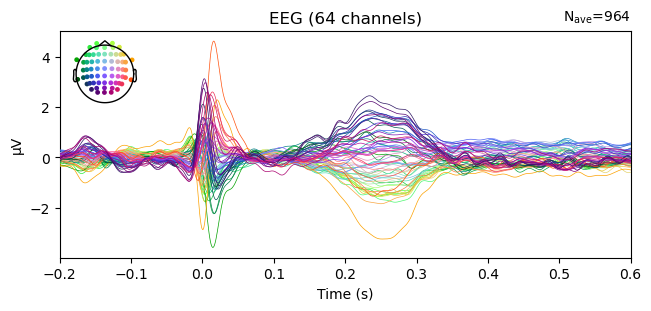

In [17]:
car_evoked.plot()

In [18]:
non_car_filt_raw = ica_non_car.load_data().copy().filter(l_freq=1.0, h_freq=40, picks = ['eeg'])

non_car_epoch = mne.Epochs(non_car_filt_raw,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ['eeg'])
non_car_evoked = non_car_epoch.average()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


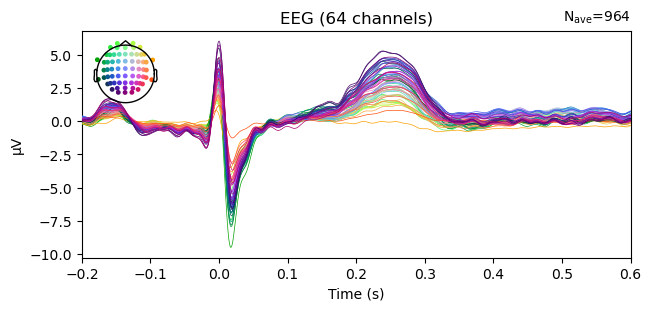

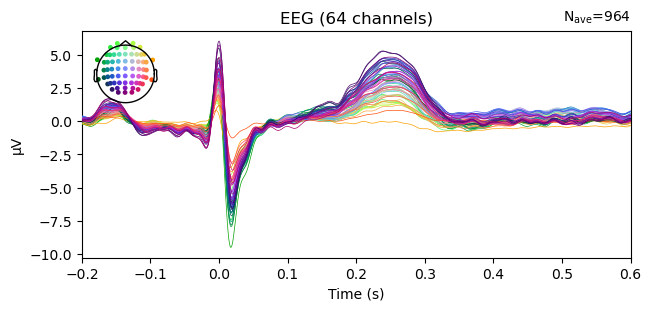

In [19]:
non_car_evoked.plot()

combining channels using "mean"
combining channels using "mean"


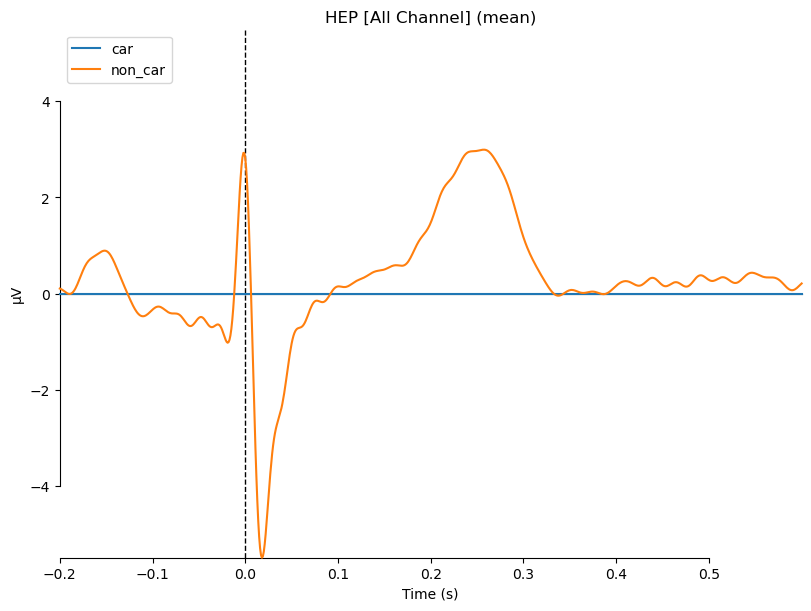

[<Figure size 800x600 with 1 Axes>]

In [20]:
evokeds = dict(car = car_evoked,non_car = non_car_evoked)
mne.viz.plot_compare_evokeds(evokeds,title = 'HEP [All Channel]', combine="mean")

# 1 Channel Comparison

In [21]:
ch = 'Pz'

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Need more than one channel to make topography for eeg. Disabling interactivity.


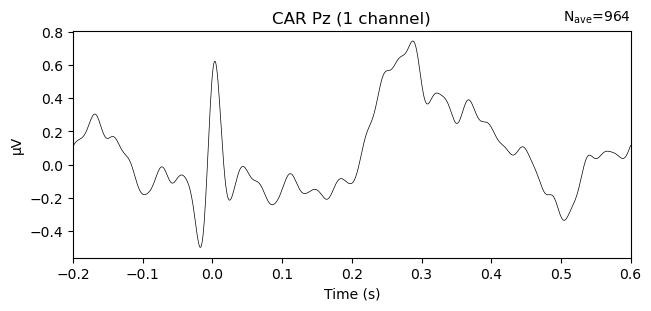

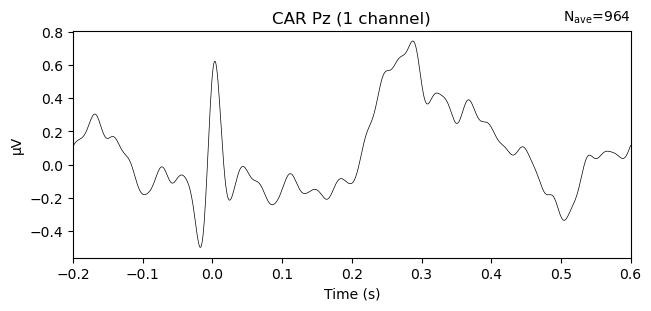

In [22]:
car_epoch_1ch = mne.Epochs(car_filt_raw,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ch)
car_evoked_1ch = car_epoch_1ch.average()
car_evoked_1ch.plot(titles = f"CAR {ch}")

Not setting metadata
965 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Need more than one channel to make topography for eeg. Disabling interactivity.


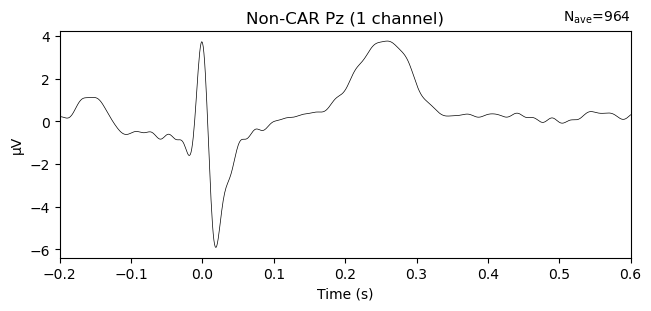

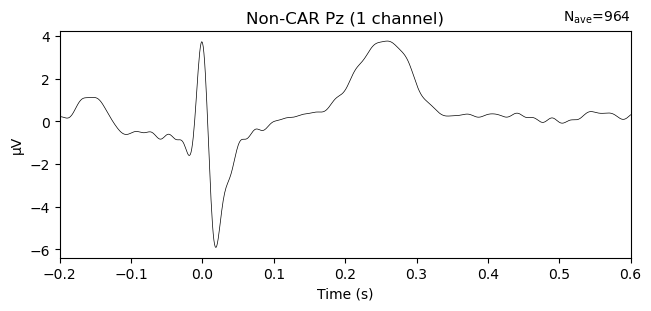

In [23]:
non_car_epoch_1ch = mne.Epochs(non_car_filt_raw,events = pan_tompkins_events, tmin= epoch_tmin, tmax = epoch_tmax, baseline = baseline, picks = ch)
non_car_evoked_1ch = non_car_epoch_1ch.average()
non_car_evoked_1ch.plot(titles = f"Non-CAR {ch}")

combining channels using "mean"
combining channels using "mean"


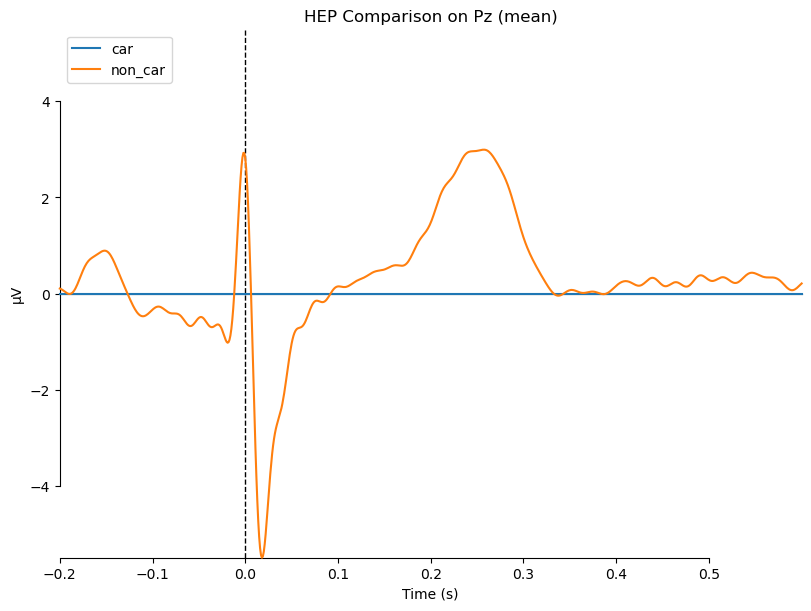

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


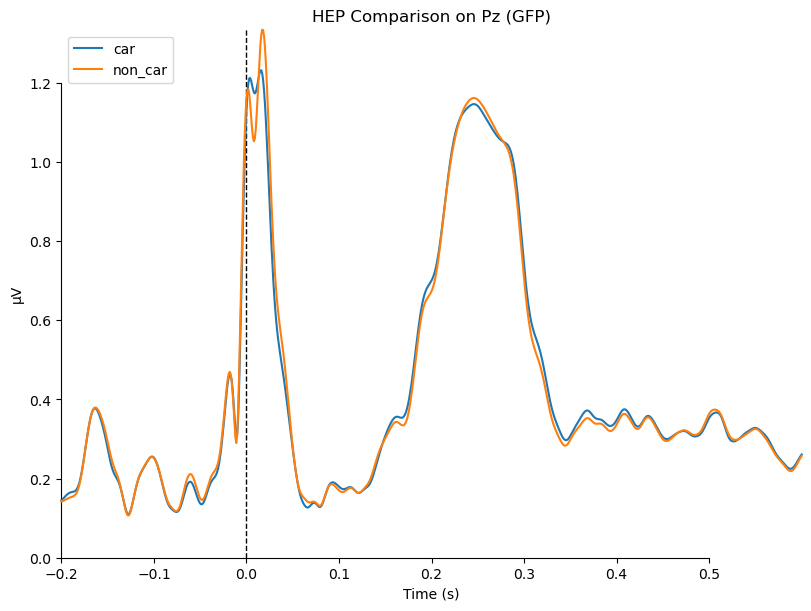

[<Figure size 800x600 with 1 Axes>]

In [24]:
title = (f"HEP Comparison on {ch}")

evokeds = dict(car = car_evoked,non_car = non_car_evoked)
mne.viz.plot_compare_evokeds(evokeds,title = title, combine="mean")
mne.viz.plot_compare_evokeds(evokeds,title = title, combine="gfp")